Project Overview

Goal:
Predict air pollution levels based on historical air quality data using time-series forecasting models (LSTMs).

Libraries Required:
pandas, numpy – Data handling
matplotlib, seaborn – Visualization
scikit-learn – Data preprocessing
tensorflow.keras or torch – LSTM model training

Step 1: Install and Import Dependencies

Run this in Google Colab

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


 Step 2: Load and Explore the Dataset

Download the dataset and load it into a Pandas DataFrame.

In [ ]:
import pandas as pd

file_path = "/content/drive/My Drive/AirQuality.csv"


df = pd.read_csv(file_path, sep=";", encoding="utf-8")

# Display first few rows and column names
print(df.head())
print(df.columns)


         Date      Time CO(GT)  PT08.S1(CO)  NMHC(GT) C6H6(GT)  PT08.S2(NMHC)  \
0  10/03/2004  18.00.00    2,6       1360.0     150.0     11,9         1046.0   
1  10/03/2004  19.00.00      2       1292.0     112.0      9,4          955.0   
2  10/03/2004  20.00.00    2,2       1402.0      88.0      9,0          939.0   
3  10/03/2004  21.00.00    2,2       1376.0      80.0      9,2          948.0   
4  10/03/2004  22.00.00    1,6       1272.0      51.0      6,5          836.0   

   NOx(GT)  PT08.S3(NOx)  NO2(GT)  PT08.S4(NO2)  PT08.S5(O3)     T    RH  \
0    166.0        1056.0    113.0        1692.0       1268.0  13,6  48,9   
1    103.0        1174.0     92.0        1559.0        972.0  13,3  47,7   
2    131.0        1140.0    114.0        1555.0       1074.0  11,9  54,0   
3    172.0        1092.0    122.0        1584.0       1203.0  11,0  60,0   
4    131.0        1205.0    116.0        1490.0       1110.0  11,2  59,6   

       AH  Unnamed: 15  Unnamed: 16  
0  0,7578         

In [ ]:
# Remove extra spaces and special characters
df.columns = df.columns.str.strip().str.replace(r'\W+', '_', regex=True)

# Print cleaned column names
print(df.columns)



Index(['Date', 'Time', 'CO_GT_', 'PT08_S1_CO_', 'NMHC_GT_', 'C6H6_GT_',
       'PT08_S2_NMHC_', 'NOx_GT_', 'PT08_S3_NOx_', 'NO2_GT_', 'PT08_S4_NO2_',
       'PT08_S5_O3_', 'T', 'RH', 'AH', 'Unnamed_15', 'Unnamed_16'],
      dtype='object')


Step 3: Data Preprocessing
1. Select Features

In [ ]:
df = df[['CO_GT_', 'T', 'RH']].copy()
df.rename(columns={'T': 'Temperature', 'RH': 'Humidity', 'CO_GT_': 'CO_Level'}, inplace=True)






2. Handle Missing Values

In [ ]:
print(df.isnull().sum())  # Check missing values

# Fill missing values using forward fill (or change as needed)
df.fillna(method='ffill', inplace=True)



CO_Level       114
Temperature    114
Humidity       114
dtype: int64


<ipython-input-104-8c19cd319783>:4: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)


3. Normalize Data

In [ ]:
# Convert columns with potential comma separators to numeric
for col in ['CO_Level', 'Temperature', 'Humidity']:
    df[col] = pd.to_numeric(df[col].astype(str).str.replace(',', '.', regex=False), errors='coerce')

# Now apply scaling
df_scaled = scaler.transform(df)


In [ ]:


import joblib
scaler = MinMaxScaler()
scaler.fit(df[['CO_Level', 'Temperature', 'Humidity']])  # Fit first!

df_scaled = scaler.transform(df[['CO_Level', 'Temperature', 'Humidity']])  # Then transform


# Save the scaler
joblib.dump(scaler, 'scaler.pkl')



['scaler.pkl']

Step 4: Create Train-Test Splits

Define time-series windows for LSTM input.

In [ ]:
def create_sequences(data, time_steps=10):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:i+time_steps])
        y.append(data[i+time_steps, 0])  # Predict CO Level
    return np.array(X), np.array(y)

time_steps = 10
X, y = create_sequences(df_scaled, time_steps)

split = int(0.8 * len(X))  # 80% training, 20% testing
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]




Step 5: Build & Train LSTM Model

Define an LSTM-based neural network:

In [ ]:
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(25),
    Dense(1)  # Predict PM2.5
])

model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_8 (LSTM)                        │ (None, 10, 50)              │          10,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 10, 50)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_9 (LSTM)                        │ (None, 50)                  │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 25)                  │           1,275 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 1)                   │              26 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 32,301 (126.18 KB)

 Trainable params: 32,301 (126.18 KB)

 Non-trainable params: 0 (0.00 B)

Train the model:

In [ ]:
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=16)


Epoch 1/50
473/473 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - loss: 0.0817 - val_loss: 0.0270
Epoch 2/50
473/473 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 0.0387 - val_loss: 0.0232
Epoch 3/50
473/473 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - loss: 0.0306 - val_loss: 0.0224
Epoch 4/50
473/473 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - loss: 0.0337 - val_loss: 0.0217
Epoch 5/50
473/473 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - loss: 0.0284 - val_loss: 0.0218
Epoch 6/50
473/473 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - loss: 0.0271 - val_loss: 0.0212
Epoch 7/50
473/473 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - loss: 0.0312 - val_loss: 0.0215
Epoch 8/50
473/473 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - loss: 0.0316 - val_loss: 0.0213
Epoch 9/50
473/473 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - loss: 0.0290 - val_loss: 0.0212
Epoch 10/50
473/473 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.0267 - val_loss: 0.0215
Epoch 11/50
473/473 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 0.0275 - val_loss: 0.0214
Epoch 12/50
473/473 ━━━━━━━━━━━━━━━━━━━━ 6s 11m

Step 7: Evaluate the Model

Plot loss curve:

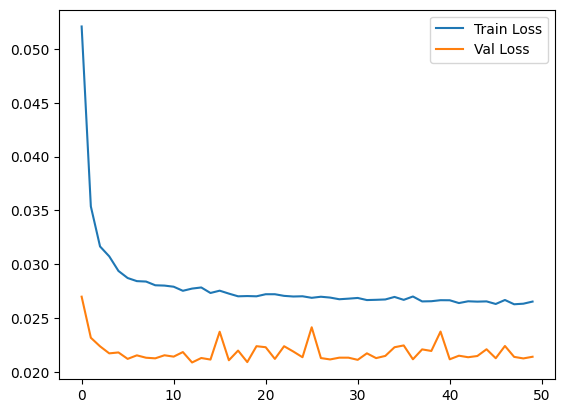

In [ ]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.show()


Predict and compare with actual values:

60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step


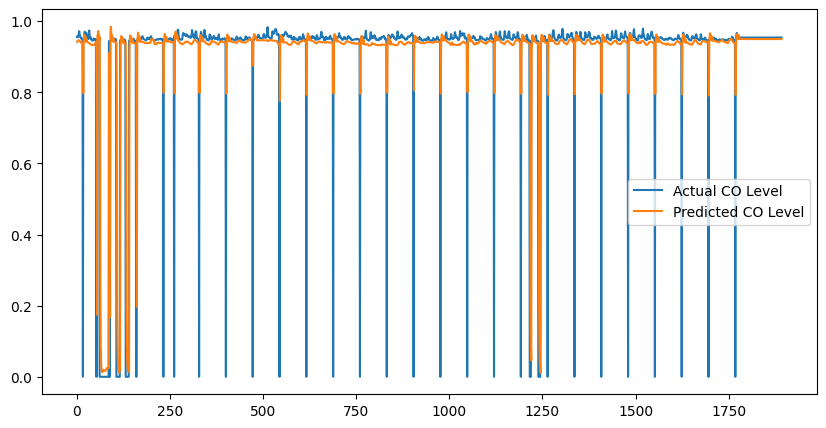

In [ ]:
y_pred = model.predict(X_test.reshape(-1, time_steps, 3))


plt.figure(figsize=(10,5))
plt.plot(y_test, label='Actual CO Level')
plt.plot(y_pred, label='Predicted CO Level')
plt.legend()
plt.show()



Step 7: Deploy trained model using
Streamlit for an interactive dashboard

In [ ]:
from google.colab import files

joblib.dump(scaler, 'scaler.pkl')
files.download('scaler.pkl')

# Save the model
model.save('air_quality_model.h5')
files.download('air_quality_model.h5')




<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
model.summary()



Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_8 (LSTM)                        │ (None, 10, 50)              │          10,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 10, 50)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_9 (LSTM)                        │ (None, 50)                  │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 25)                  │           1,275 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 1)                   │              26 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 96,905 (378.54 KB)

 Trainable params: 32,301 (126.18 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 64,604 (252.36 KB)